Naive Bayes is an extremely simple classification scheme that often works amazingly well in practice.  We'll apply it to a very simple dataset having to do with the survival of lobsters.  We'll begin by importing the numerical library numpy, which allows us to manipulate arrays, the data management library pandas, and the plotting utility matplotlib


/home/brinkerhoff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


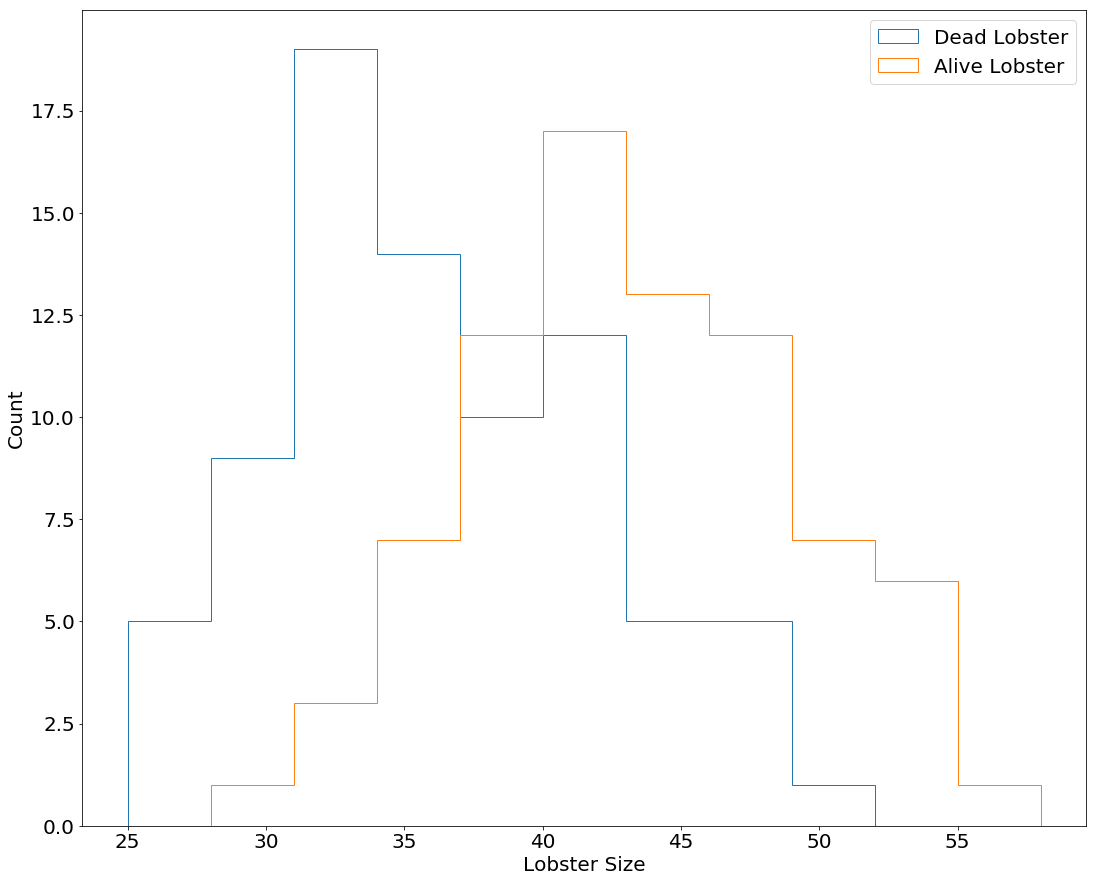

In [21]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,15)
mpl.rcParams['font.size'] = 20
import matplotlib.pyplot as plt

data = pd.read_csv('datasets/lobster_survive.dat',header=0,sep=r"\s{2,}")
X = data['Len'].values.astype(float)
Y = data['Survive'].values.astype(float)
m = len(t) #Number of da

N_classes = 2

plt.hist(X[Y==0],label='Dead Lobster',bins=np.arange(25,60,3),histtype='step')
plt.hist(X[Y==1],label='Alive Lobster',bins=np.arange(25,60,3),histtype='step')
plt.xlabel('Lobster Size')
plt.ylabel('Count')
plt.legend()
plt.show()


The method works in a two step processs: First, for a set of classes $C_k \in \{C_1,C_2,\ldots,C_N\}$, where $N$ is the number of possible class labels (2 in this case), use Bayes' rule to generate a probability that a data instance with a set of features $x$ belongs to each class, given a set of training data $D=(X,Y)$.  In step two, assign the class label with the highest probability to that data instance.  For each class $C_k$, we can use Bayes' rule to determine the probability:
$$ 
P(C_k|\mathbf{X},D) \propto P(\mathbf{X}|D,C_k) P(C_k|D).
$$
However, this equation implies that we have to compute the joint probability of $\mathbf{x}$, where there could be some complicated correlations between features.  We can simplify this model by assuming that all of the features ($x_i \in \mathbf{X}$) are independent, or
$$ P(\mathbf{x}|D,C_k) \approx \prod_{j=1}^n P(x_j|D,C_k), $$
where $n$ is the number of features in a data instance.  This is the so-called *naive Bayes* assumption, naive because it assumes no correlation between features.  This leads to the simpler model:
$$
P(C_k|\mathbf{x},D) \propto P(C_k|D) \prod_{j=1}^n P(x_j|D,C_k).
$$

Now, we need to specify the distributions for the class prior $P(C_k|D)$ and class likelihoods $P(x_i|D,C_k)$.  We can model the prior probability as a Bernoulli distribution 
$$P(C=C_k|D) = \eta_k, $$
where $\eta_k$ is the probability that we would label the feature $\mathbf{x}$ as class $C_k$, before having seen any of the values in $\mathbf{x}$.  There are different options here.  We could say that all classes are equally likely, so $\eta=1/N$.  A more common practice is to estimate $\eta$ as the maximum likelihood value from the training data $D$, which for a Bernoulli distribution is 
$$
\eta_k = \frac{\sum_{i=1}^n [C = C_k]}{\sum_{i=1}^n},
$$
or the total proportion of the training data where the label is $C_k$.  Note the use of the [Iverson Bracket](https://en.wikipedia.org/wiki/Iverson_bracket) in the above definition.



In [25]:
etas = np.zeros((N_classes))
for C_k in [0,1]:
    etas[C_k] = len(Y[Y==C_k])/len(Y)
print(etas) #About fifty/fifty : a balanced dataset

[0.50314465 0.49685535]


For the likelihood, since we're considering continuous features, it makes sense to use a continous likelihood function.  While there are many options, a normal distribution should do the trick.  However, we need to use the training data to estimate the parameters of this normal distribution.  This is similar to what we did for the prior:
$$
P(x_j|C_k,D) = \int P(x_j|\mu_j,\sigma_j^2)\, P(\mu_j|C_k,D) \, P(\sigma_j^2|C_k,D) \;\mathrm{d}\mu_j\, \mathrm{d}\sigma_j^2.
$$
Assigning complete probability distributions to $\mu_j$ and $\sigma_j^2$ is the Bayesian thing to do, but leads to some complicated math and perhaps no analytical solution.  Instead, let's do what we did before and compute $\mu_j$ and $\sigma_j^2$ using maximum likelihood estimators, which for normally-distributed data are given by
$$
\mu_{jk,MLE} = \frac{\sum_{i=1}^n x_{ji} [C_i=C_k]}{\sum_{i=1}^n [C_i=C_k]},
$$
and 
$$
\sigma_{jk,MLE}^2 = \frac{ (\sum_{i=1}^n (x_{ji} - \mu_j)^2 [C_i=C_k])}{(\sum_{i=1}^n [C_i=C_k]) - 1},
$$
which are just the sample mean and sample variance of the training data examples for which the class is $C_k$.

In [29]:
mus = np.zeros((N_classes))
variances = np.zeros((N_classes))
for C_k in [0,1]:
    mus[C_k] = np.mean(X[Y==C_k])
    variances[C_k] = np.std(X[Y==C_k])**2
print(mus,variances)

[36.825      43.82278481] [33.969375   34.04454414]


Now, we can just evaluate the probability of each example, with respect to each class, and classify as the one with the highest probability.

In [34]:
class_posterior = np.zeros((n,N_classes))

for i in range(n):
    for C_k in range(N_classes):
        likelihood = 1./np.sqrt(2*np.pi*variances[C_k])*np.exp(-(X[i] - mus[C_k])**2/(2*variances[C_k]))
        prior = etas[C_k]
        class_posterior[i,C_k] = likelihood*prior
    class_posterior[i,:]/=np.sum(class_posterior[i])

print(class_posterior)

[[0.9398707  0.0601293 ]
 [0.9398707  0.0601293 ]
 [0.9398707  0.0601293 ]
 [0.9398707  0.0601293 ]
 [0.9398707  0.0601293 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.71144839 0.28855161]
 [0.71144839 0.28855161]
 [0.71144839 0.28855161]


This is easier to understand if we plot it:

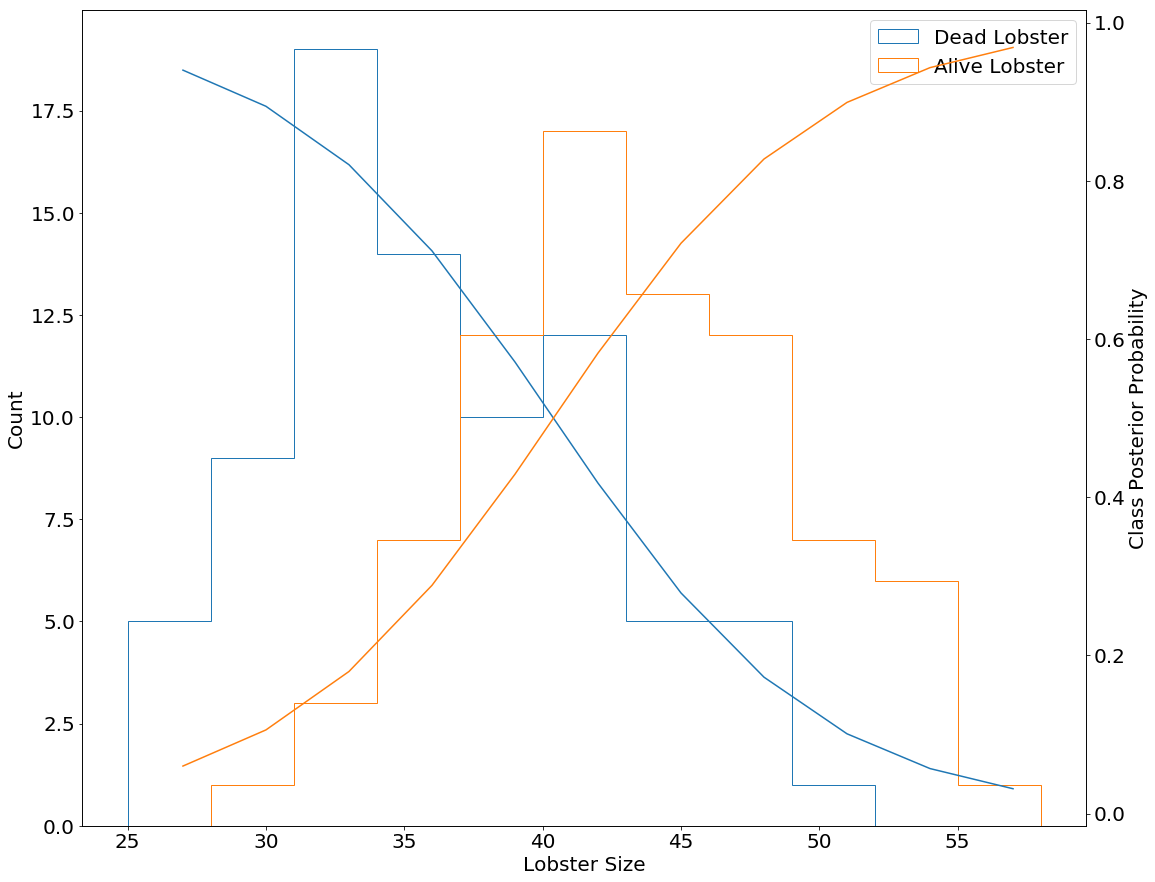

In [38]:
plt.hist(X[Y==0],label='Dead Lobster',bins=np.arange(25,60,3),histtype='step')
plt.hist(X[Y==1],label='Alive Lobster',bins=np.arange(25,60,3),histtype='step')
plt.xlabel('Lobster Size')
plt.ylabel('Count')
plt.legend()

ax2 = plt.twinx()
ax2.plot(X,class_posterior[:,0])
ax2.plot(X,class_posterior[:,1])
ax2.set_ylabel('Class Posterior Probability')
plt.show()


Let's try something similar with the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set), which was first introduced by Ronald A. Fisher in 1936.  It provides four features: petal length, petal width, sepal length, and sepal width, along with a class label that divides the data into three classes: *Iris setosa, Iris virginica and Iris versicolor*.  It has since become a classic for testing machine learning algorithms, and is available in scikit-learn.  Let's import it and have a look:

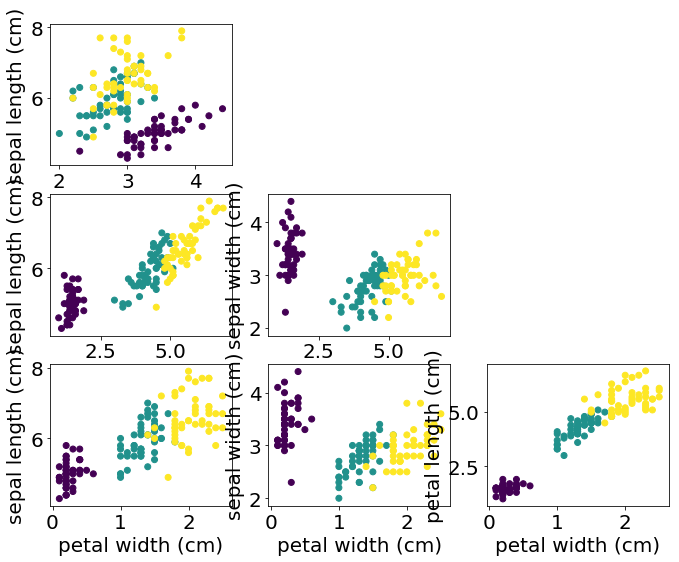

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [15,12]
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load the dataset
iris = datasets.load_iris()
X = iris.data    # n x m matrix of features 
y = iris.target  # n vector of classes

# Why do we do this?
#X,X_test,y,y_test = train_test_split(X,y,test_size=0.33,random_state=42) # Split into 33% test and 67% training sets 

classes = [0,1,2] #Numeric class identifiers: 0 -> Setosa, 1-> Versicolor, 2-> Virginica

# 2D plots of all possible permutations of 2 features out of 4 produces 4 choose 2 plots
fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X[:,i],X[:,j],c=y)
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.show()


In [41]:
m = X.shape[0]  # Number of data instances=
N = 3           # Number of classes
n = X.shape[1]  # Number of features

For each class, we will need the $n$ values of $\mu_i$ and $\sigma_i^2$, let's define $n \times N$ arrays to hold these values, as well as the $N$ prior probabilities that we will need

In [42]:
mu_array = np.zeros((n,N))
sigma2_array = np.zeros((n,N))
prior_array = np.zeros((N))

Then we can compute these values by looping over the $N$ classes 

In [43]:
#Learning phase
for k in range(N):    #Loop over each class label
    C_k = classes[k]
    prior = sum(y==C_k)/float(y.shape[0])                           # Count the number of data where the label is C_k
    mu = np.sum(X[y==C_k],axis=0)/len(X[y==C_k])                    # Take the mean of those features where the corresponding label is C_k
    sigma2 = np.sum((X[y==C_k] - mu)**2,axis=0)/(len(X[y==C_k])-1)  # Take the variance of those features where the corresponding label is C_k
    mu_array[:,k] = mu                                              # Store in the arrays we created above
    sigma2_array[:,k] = sigma2
    prior_array[k] = prior
    
mu_array

array([[5.006, 5.936, 6.588],
       [3.418, 2.77 , 2.974],
       [1.464, 4.26 , 5.552],
       [0.244, 1.326, 2.026]])

And that's it for the training phase.  Naive Bayes models, particularly when they compute the parameters of the likelihood model with maximum likelihood estimation are very efficient.  We can perform a similar loop over classes to make predictions.  First, let's compute the class probabilities for each entry in the training set:

In [52]:
# Training set predictions
class_probabilities = np.zeros((m,N))  # The probabilities for 

for i,x in enumerate(X):  # Loop over the training data instances
    for k in range(N):    # Loop over the classes
        prior = prior_array[k]
        mu = mu_array[:,k]
        sigma2 = sigma2_array[:,k]
        likelihood = np.prod(1./np.sqrt(2*np.pi*sigma2)*np.exp(-(x-mu)**2/(2*sigma2)))
        posterior_k = prior*likelihood
        class_probabilities[i,k] = posterior_k
        
class_probabilities /= np.sum(class_probabilities,axis=1,keepdims=True)
print (class_probabilities[:,:])


[[1.00000000e+000 3.04095209e-018 2.19543253e-025]
 [1.00000000e+000 3.10348733e-017 6.79393165e-025]
 [1.00000000e+000 2.37843204e-018 7.27558235e-026]
 [1.00000000e+000 3.01450438e-017 8.53463250e-025]
 [1.00000000e+000 1.04395208e-018 9.11825632e-026]
 [1.00000000e+000 2.78151625e-014 4.44624481e-021]
 [1.00000000e+000 2.39058030e-017 8.22548346e-025]
 [1.00000000e+000 1.39963000e-017 8.21913418e-025]
 [1.00000000e+000 1.92884851e-017 3.49537066e-025]
 [1.00000000e+000 6.91680285e-018 3.38906074e-025]
 [1.00000000e+000 9.62830931e-018 1.51106801e-024]
 [1.00000000e+000 3.46277785e-017 2.09411948e-024]
 [1.00000000e+000 2.62133341e-018 9.44207800e-026]
 [1.00000000e+000 1.72175805e-019 5.80025521e-027]
 [1.00000000e+000 5.86392436e-019 2.63324221e-025]
 [1.00000000e+000 6.55300223e-017 4.71051804e-023]
 [1.00000000e+000 1.16209922e-016 1.34666518e-023]
 [1.00000000e+000 5.01922021e-017 2.43613737e-024]
 [1.00000000e+000 1.16455770e-014 2.65467601e-021]
 [1.00000000e+000 1.89211112e-0

Now we can classify by finding the class with the highest probability

In [53]:
y_pred_train = np.argmax(class_probabilities,axis=1)
y_pred_train


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [54]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

A nice way to look at classification accuracy is with a confusion matrix.  Its entries $p,q$ are just counts corresponding to the predicted class (row) versus the true class (column):

In [55]:
cm_train = confusion_matrix(y,y_pred_train)
print (cm_train)
print ("training accuracy:", 1 - sum(abs(y-y_pred_train))/float(m))


[[50  0  0]
 [ 0 47  3]
 [ 0  3 47]]
training accuracy: 0.96


Finally, let's plot the data as we did above, but this time highlight the misclassified features

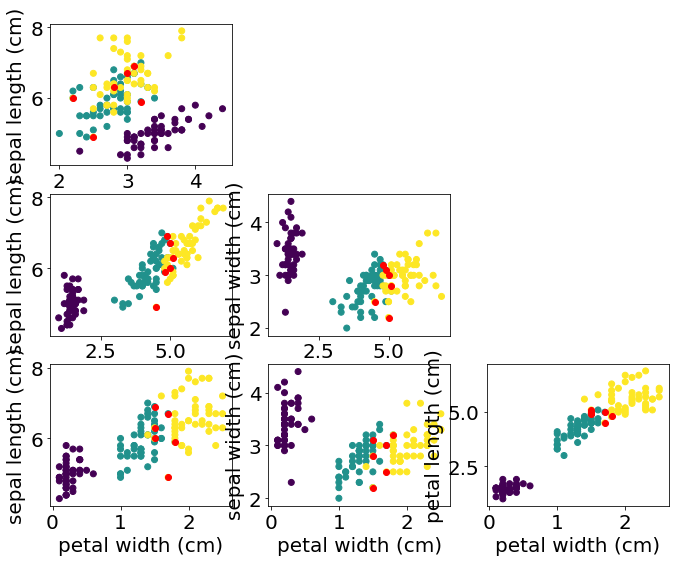

In [56]:
# 2D plots of all possible permutations of 2 features out of 4 produces 4 choose 2 plots
fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X[:,i],X[:,j],c=y)
            axs[i,j].plot(X[y!=y_pred_train,i],X[y!=y_pred_train,j],'ro')
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.show()

Not so surprisingly, the misclassifications fall near the boundaries between classes.  The great thing about Naive Bayes is that it works better as the dimensionality of the features increases, because overlaps in feature space become exponentially less common.